In [1]:
import xarray as xr
import ghibtools as gh
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pingouin
from compute_rri import ecg_job
from compute_resp_features import respiration_features_job
from compute_eda import eda_job
from compute_bandpower import bandpower_job
from compute_power_at_resp import power_at_resp_job
from params import *
from bibliotheque import get_pos
import physio
from configuration import base_folder
import os

In [52]:
metrics = {
    'hrv':['HRV_Mean', 'HRV_SD', 'HRV_Median', 'HRV_Mad','HRV_CV', 'HRV_MCV', 'HRV_RMSSD'],
    'eda':['Tonic', 'N_SCR', 'SCR_Height','SCR_Amplitude', 'SCR_RiseTime', 'SCR_RecoveryTime'],
    'resp':['cycle_duration', 'inspi_duration', 'expi_duration', 'cycle_freq',
       'cycle_ratio', 'inspi_volume', 'expi_volume', 'total_amplitude',
       'inspi_amplitude', 'expi_amplitude', 'total_volume'],
    'bandpower':['power_integral','power_median'],
    'power_at_resp':['max_eeg']
}

In [24]:
def get_hrv(run_keys):
    concat = []
    for run_key in run_keys:
        participant,session = run_key.split('_')
        peaks = ecg_job.get(run_key)['ecg_peaks']
        metrics = physio.compute_ecg_metrics(peaks, srate)
        df = metrics.to_frame().T
        df.insert(0 , 'session', session)
        df.insert(0 , 'participant', participant)
        concat.append(df)
    hrv = pd.concat(concat)
    return hrv

In [25]:
def get_eda(run_keys):
    concat = []
    for run_key in run_keys:
        concat.append(eda_job.get(run_key).to_dataframe())
    eda = pd.concat(concat)
    return eda

In [26]:
def get_power_at_resp(run_keys):
    concat = []
    for run_key in run_keys:
        participant, session = run_key.split('_')
        power_at_resp_participant = power_at_resp_job.get(run_key).to_dataframe()
        concat.append(power_at_resp_participant)
    power_at_resp = pd.concat(concat).reset_index(drop = True)
    return power_at_resp

In [27]:
def get_bandpower(run_keys):
    concat = []
    for run_key in run_keys:
        concat.append(bandpower_job.get(run_key).to_dataframe())
    bandpower = pd.concat(concat)
    return bandpower

In [28]:
def get_resp_features(run_keys):
    concat = []

    for run_key in run_keys:
        participant, session = run_key.split('_')
        features = respiration_features_job.get(run_key).to_dataframe()
        features.insert(0, 'session', session)
        features.insert(0, 'participant', participant)
        features = features.groupby(['participant','session']).median().reset_index()
        concat.append(features)
    resp = pd.concat(concat)
    return resp

In [29]:
hrv = get_hrv(run_keys)

In [30]:
eda = get_eda(run_keys)

In [31]:
resp = get_resp_features(run_keys)

In [32]:
bandpower = get_bandpower(run_keys)

In [34]:
alpha = bandpower[bandpower['band'] == 'alpha'].groupby(['participant','session']).mean(numeric_only = True).reset_index()

In [47]:
power_at_resp = get_power_at_resp(run_keys)

In [51]:
power_at_resp_gby = power_at_resp.groupby(['participant','session']).mean(numeric_only = True).reset_index()

In [53]:
concat = []

for label, df in zip(['hrv','eda','resp','bandpower','power_at_resp'],[hrv, eda, resp, alpha, power_at_resp_gby]):
    concat.append(df[metrics[label]].reset_index(drop=True))

In [54]:
grouping = pd.concat(concat, axis = 1)

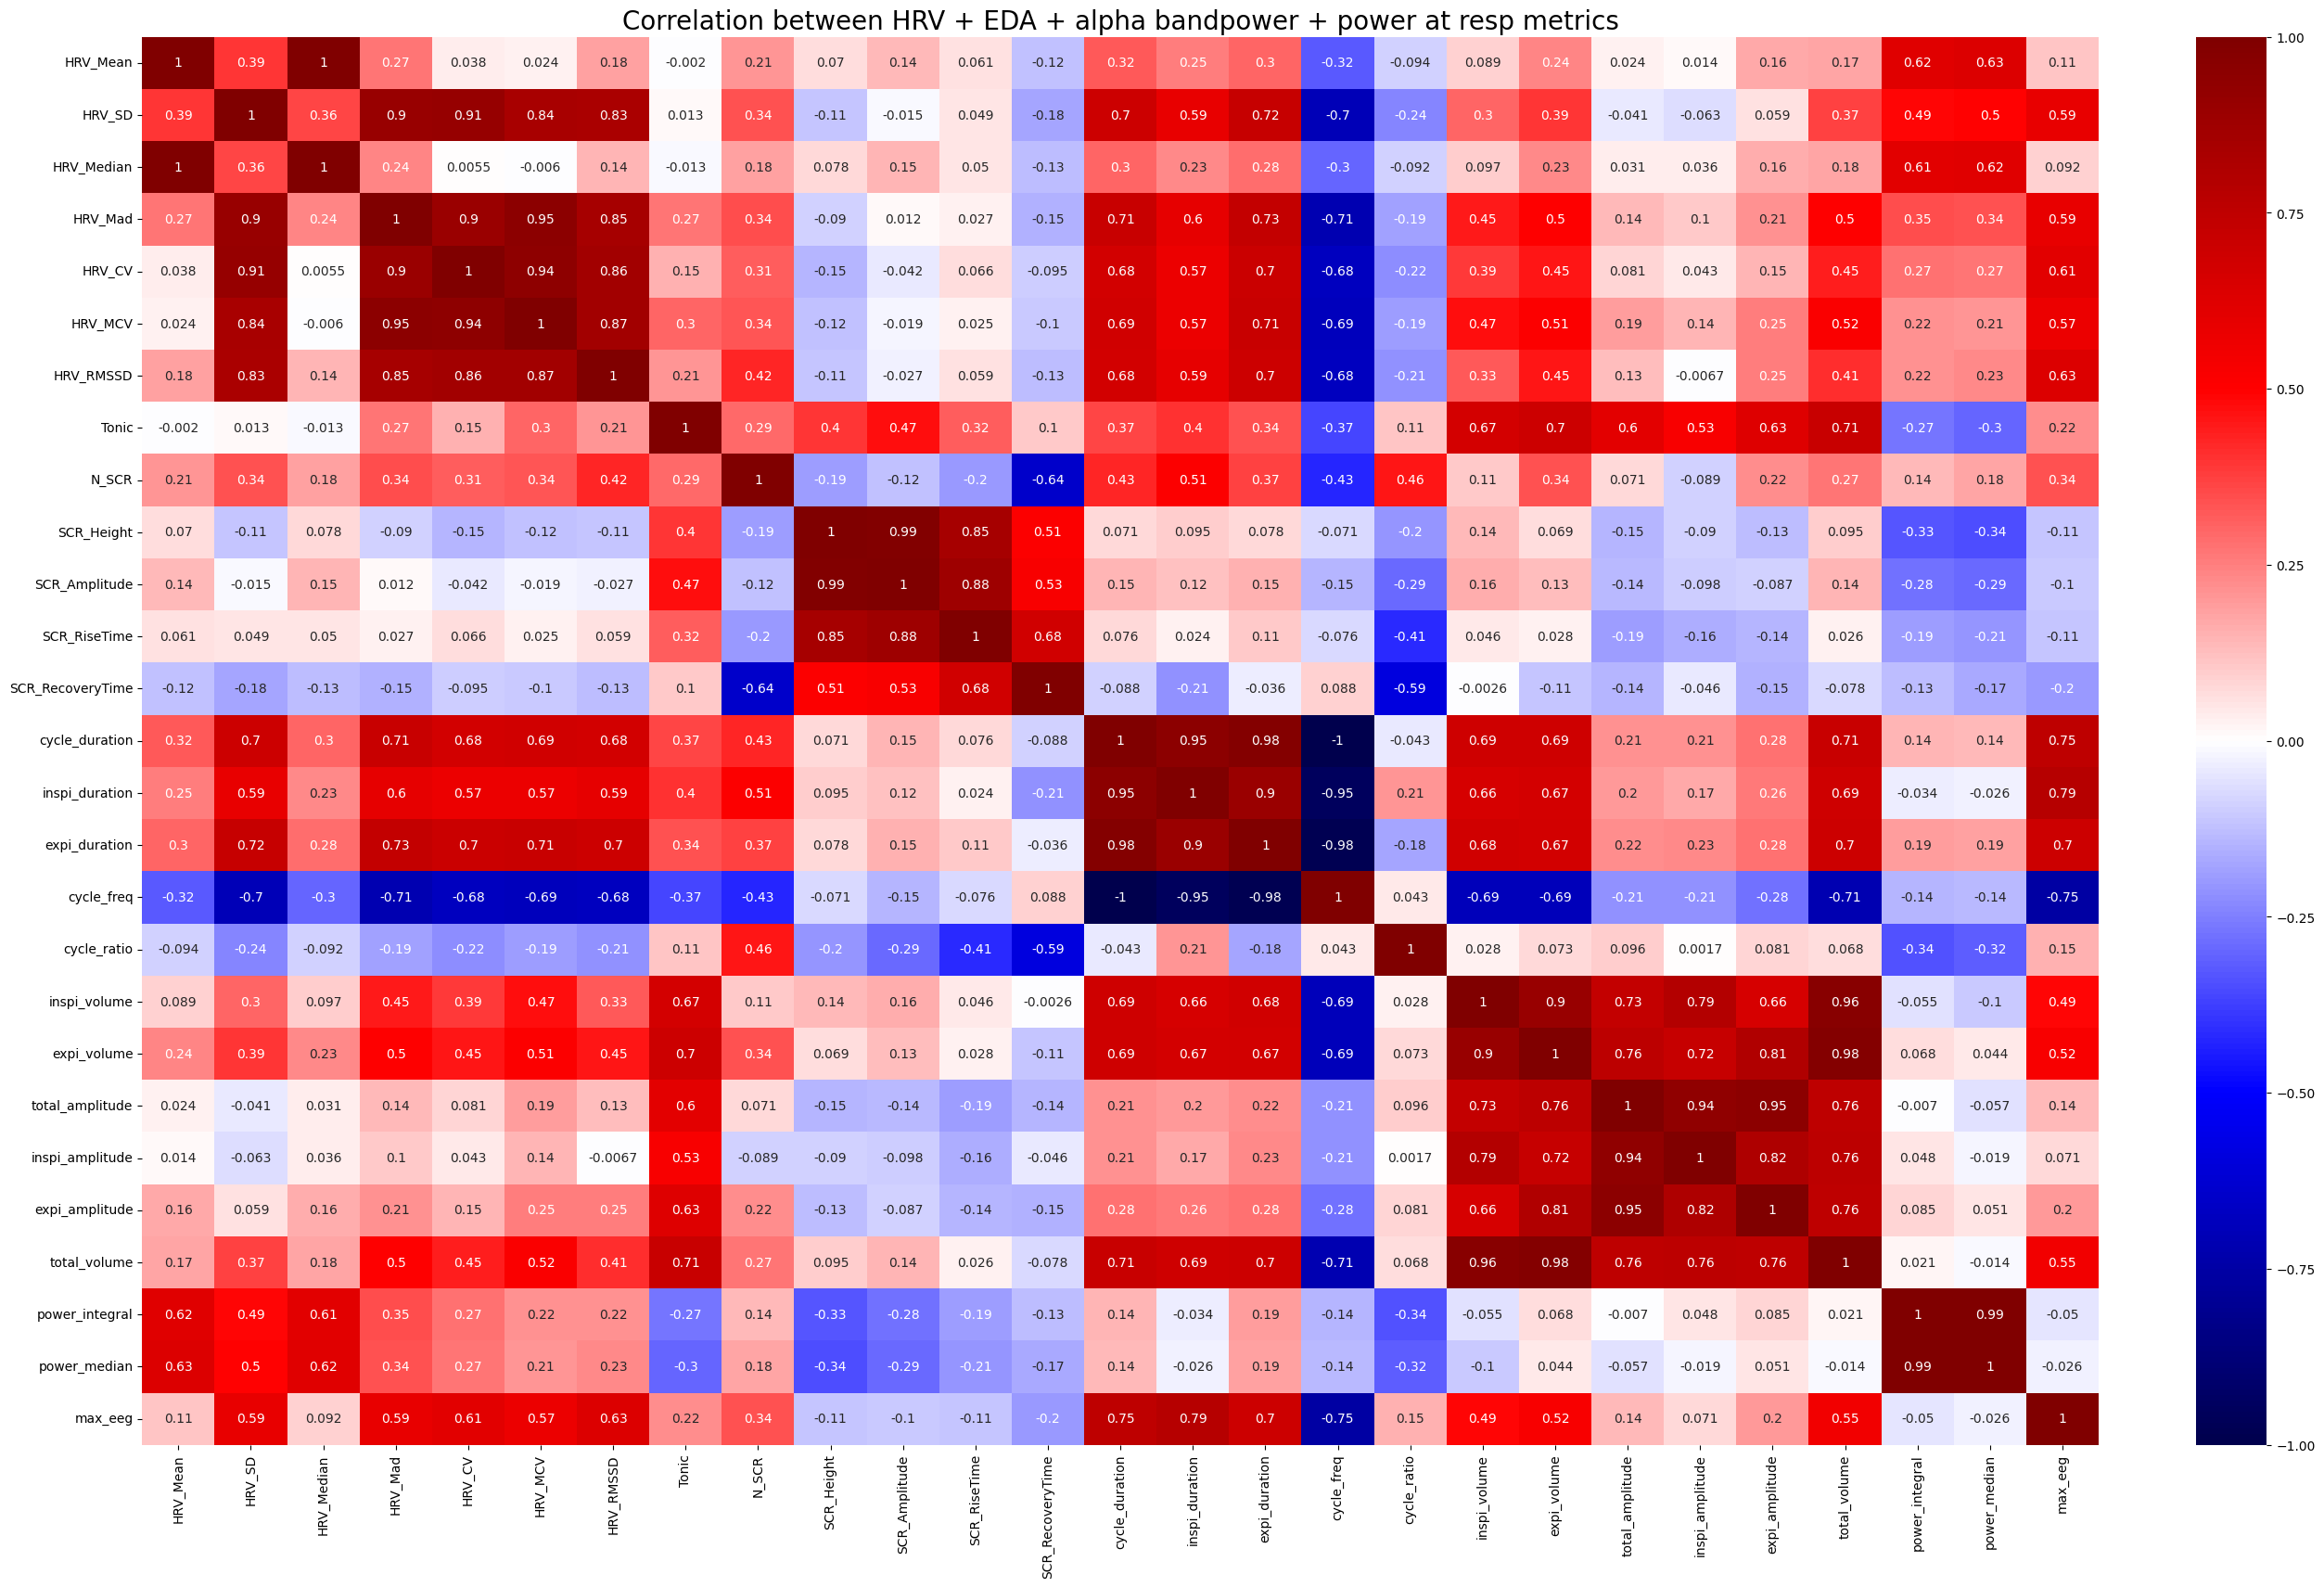

In [58]:
fig, ax = plt.subplots(figsize =(25, 17), constrained_layout = True)
sns.heatmap(grouping.corr('spearman'), annot = True, vmin = -1, vmax = 1, cmap = 'seismic',ax=ax)
ax.set_title('Correlation between HRV + EDA + alpha bandpower + power at resp metrics', fontsize = 20)
file = base_folder / 'Figures' / 'big_correlation.png'
fig.savefig(file, bbox_inches = 'tight')